In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1,as_frame=False,parser='auto')
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X , y = mnist['data'], mnist['target']

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

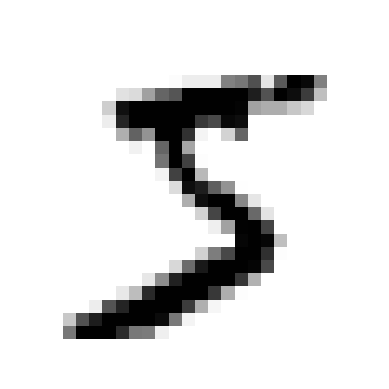

In [6]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary)
plt.axis("off")
plt.savefig("some_digit_plot")
plt.show()

In [7]:
y[0]

'5'

In [8]:
import numpy as np
y = y.astype(np.uint8)

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
# Binary Classifier for 5's
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [11]:
# Stochastic Gradient Descent Classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict(X[0].reshape(1,-1))

array([ True])

In [13]:
# Implementing Cross-Validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)
# skfolds.split performs stratified sampling based on y_train_5 values so that proportional
#  number of actual 5's are present in each fold
for train_index, test_index in skfolds.split(X_train, y_train_5):
    # train and test indices are lists containing the proper folds/groupings from 
    # stratified sampling
    print("Train index: ", train_index, " Test Index: ", test_index)
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds,y_train_folds)

    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/ len(y_pred))


Train index:  [    1     3     4 ... 59994 59996 59998]  Test Index:  [    0     2     6 ... 59995 59997 59999]
0.9669
Train index:  [    0     2     3 ... 59997 59998 59999]  Test Index:  [    1    10    11 ... 59988 59989 59991]
0.91625
Train index:  [    0     1     2 ... 59995 59997 59999]  Test Index:  [    3     4     5 ... 59994 59996 59998]
0.96785


In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [17]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1),dtype=bool)

In [18]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

In [19]:
# still 90% because only about 10% of the images are 5s. Therefore, if you always guess
# that the image is not a 5, you would be right 90% of the time == skewed dataset

In [20]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [23]:
y_train_perfect_prediction = y_train_5 # pretend we have perfect predictions
# showing how the confusion_matrix works
confusion_matrix(y_train_5, y_train_perfect_prediction)

array([[54579,     0],
       [    0,  5421]])

In [25]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # 3530 / (3530 + 687) 

0.8370879772350012

In [26]:
recall_score(y_train_5, y_train_pred)  # 3530 / (3530 + 1891)

0.6511713705958311

In [28]:
from sklearn.metrics import f1_score 
f1_score(y_train_5, y_train_pred) # harmonic mean: gives more weight to low scores
# therefore, both recall and precision must be high to get a high f1 score. Otherwise,
# low scores have a bigger influence on the f1 score

0.7325171197343846

In [29]:
# precision/recall trade-off: can't have both. Increasing precision reduces recall 
# vice versa

# **Recall vs Precision**

In [34]:
y_scores = sgd_clf.decision_function(X_train[0].reshape(1,-1))

In [35]:
y_scores

array([2164.22030239])

In [36]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [37]:
y_some_digit_pred

array([ True])

In [38]:
threshold = 3000
(y_scores > threshold)

array([False])

In [39]:
# Decision Function results for all training data
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                             method = "decision_function")

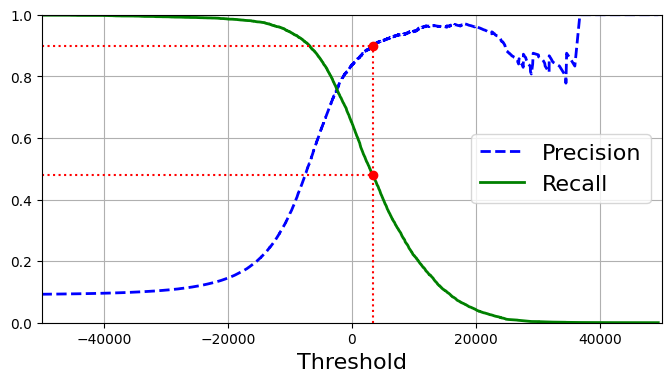

In [44]:
# Plot these scores
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.savefig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()


In [45]:
# Search for lowest threshold taht gives you at least 90% precision

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [46]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [48]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

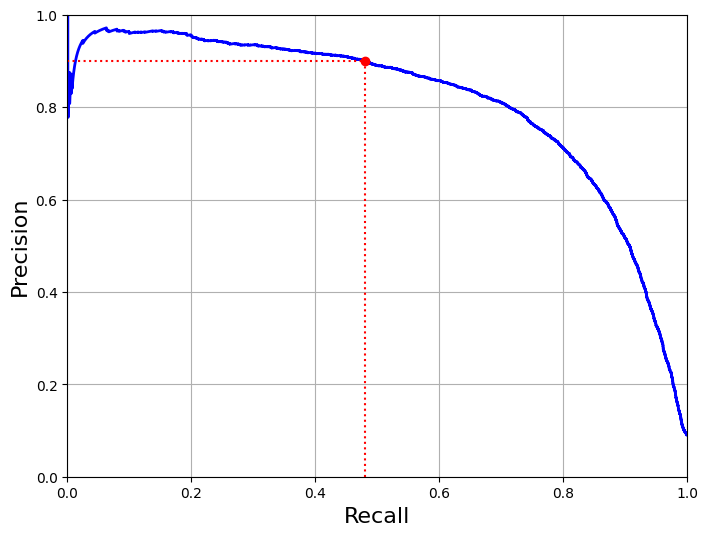

In [50]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.savefig("precision_vs_recall_plot")
plt.show()

# The ROC Curve

In [51]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

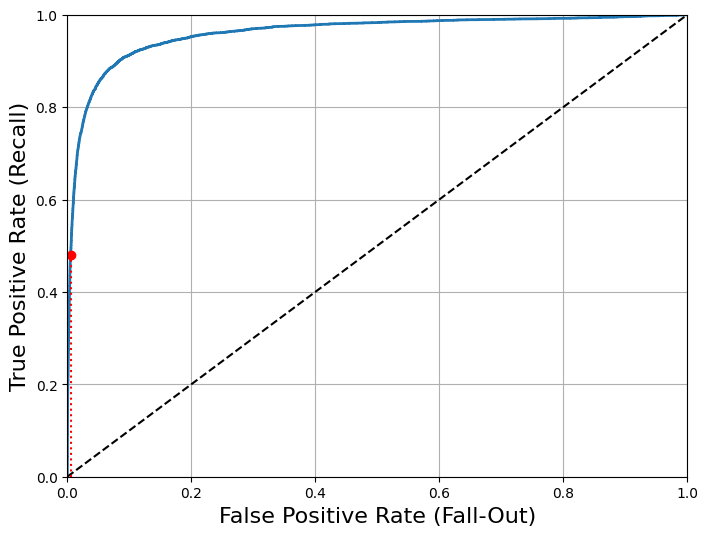

In [52]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
plt.savefig("roc_curve_plot")                                    # Not shown
plt.show()

In [54]:
# Perfect classifierhas ROC AUC = 1; random classifier has ROC AUC = 0.5
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

In [55]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, method="predict_proba")

In [56]:
y_scores_forest = y_probas_forest[:,1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

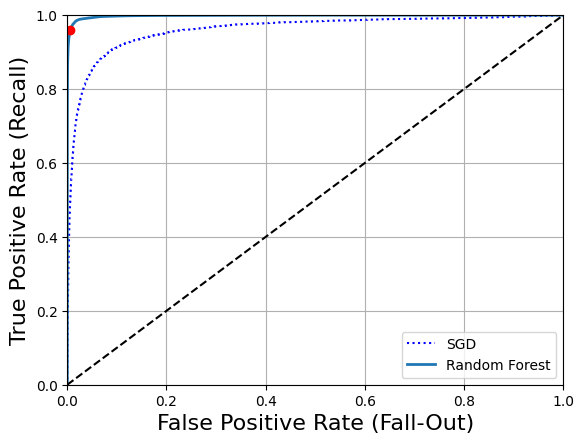

In [59]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]
plt.plot(fpr,tpr,"b:", label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
plt.plot(fpr_90,recall_for_forest,"ro")
plt.legend(loc="lower right")
plt.show()

In [60]:
roc_auc_score(y_train_5,y_scores_forest)

0.998402186461512